# Model training

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [3]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split dataset
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']

# Reduce dataset size for test purpose
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

0    11696
1     1095
Name: HeartDisease, dtype: int64

## Global variables

In [4]:
scorer = make_scorer(fbeta_score, beta=2)

## Method for ROC plotting

In [5]:
def plot_roc(y_test, y_predicted):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic (ROC)')

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return figure

## Method for evaluation

In [6]:
def evaluate_results(y_test, y_predicted):
    plot_roc(y_test, y_predicted)

    return {'accuracy': accuracy_score(y_test, y_predicted),
            'recall': recall_score(y_test, y_predicted),
            'precision': precision_score(y_test, y_predicted),
            'f1_score': f1_score(y_test, y_predicted),
            'f2_score': fbeta_score(y_test, y_predicted, beta=2)}

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

{'accuracy': 0.8427141963727329,
 'recall': 0.0948905109489051,
 'precision': 0.09252669039145907,
 'f1_score': 0.0936936936936937,
 'f2_score': 0.09440813362381989}

<Figure size 432x288 with 0 Axes>

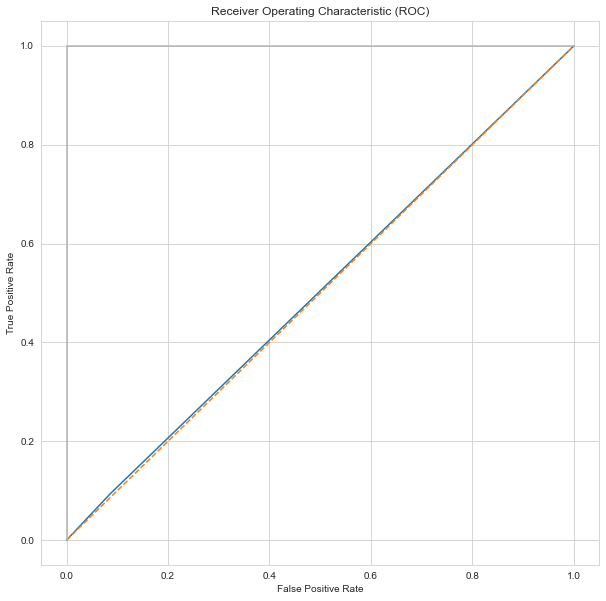

In [7]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

evaluate_results(y_test, y_predicted)

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model evaluation method

Function that provides evaluation for passed model estimator with different parameters.

In [8]:
def model_eval(estimator, parameters, X_train, y_train, X_test, y_test, scoring=scorer, verbose=0):
    # specify the cross validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator,
                                         param_grid=parameters,
                                         scoring=scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=verbose
                                         )

    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    display(grid_search_estimator.best_params_)

    return evaluate_results(y_test, y_predicted)

## Knn

{'n_neighbors': 3}

{'accuracy': 0.9040025015634772,
 'recall': 0.14233576642335766,
 'precision': 0.35135135135135137,
 'f1_score': 0.20259740259740258,
 'f2_score': 0.16155758077879037}

<Figure size 432x288 with 0 Axes>

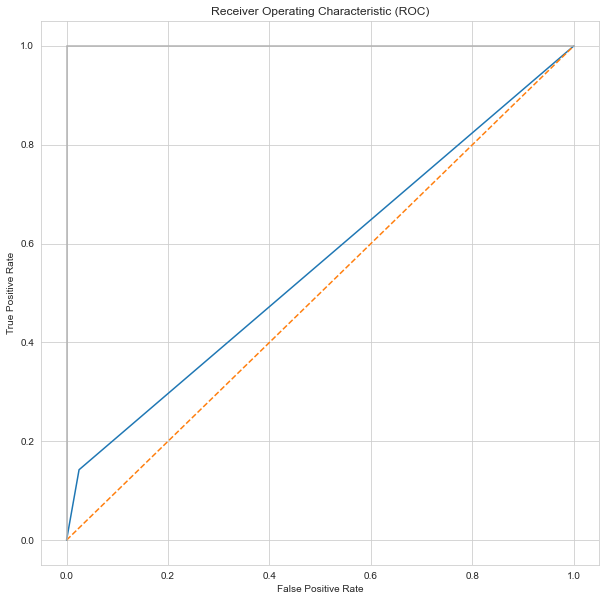

In [9]:
# create an estimator
knn_estimator = KNeighborsClassifier()

# specify the parameter grid
parameters = {
    'n_neighbors': [2, 3, 5]
}

# train model and display evaluation
display(model_eval(estimator=knn_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))


## Random Forest

{'class_weight': {0: 1, 1: 2}, 'n_estimators': 3}

{'accuracy': 0.8933708567854909,
 'recall': 0.1678832116788321,
 'precision': 0.2893081761006289,
 'f1_score': 0.21247113163972287,
 'f2_score': 0.18326693227091634}

<Figure size 432x288 with 0 Axes>

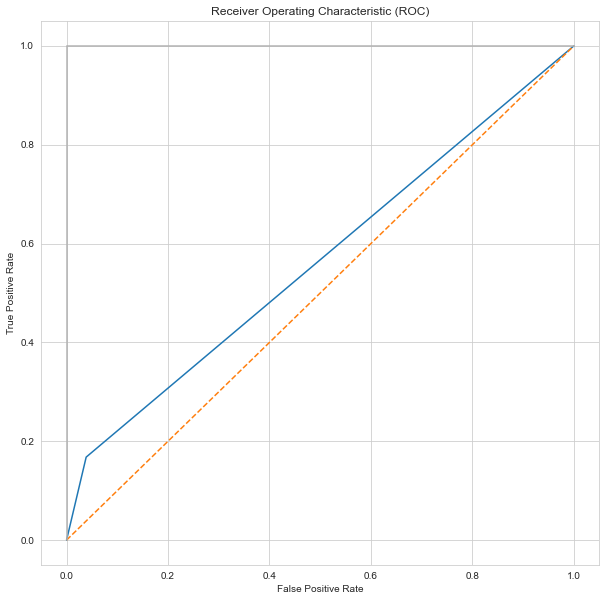

In [9]:
# create an estimator
forest_estimator = RandomForestClassifier()

# specify the parameter grid
parameters = {
    'class_weight': [{0:1, 1:2}, {0:1, 1:1}],
    'n_estimators': [2, 3, 4, 5]
}

# train model and display evaluation
display(model_eval(estimator=forest_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

## Support Vector Machine

In [ ]:
# create an estimator
svc_estimator = SVC(random_state=0)

# specify the parameter grid
parameters = {
    'kernel': ['linear', 'poly']
}

# train model and display evaluation
display(model_eval(estimator=svc_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

## Neural Net

In [ ]:
# create an estimator
nn_estimator = MLPClassifier(random_state=1, max_iter=300)

# specify the parameter grid
# TODO JG: adjust parameter
parameters = {
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

# train model and display evaluation
display(model_eval(estimator=nn_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))